# Figure 4: Non-gaussian residual noise

<div style="text-align: justify">
This code is used to create **Figure 4** in the **Apples with Apples** paper [(Bonse et al. 2023)](../../05_citation.rst). The Figure gives an example for a dataset in which the pixel noise distribution of an ADI residuals is not Gaussian. We note, that the pixel values extracted from the residuals are not independent. The shown Q-Q plots only provide indicative evidence for the type of residual noise. But, they are not a proof for or against Gaussian distributed noise.
</div>

## Imports

In [1]:
import os
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.gridspec as gridspec

from applefy.gaussianity.residual_tests import extract_circular_annulus, gaussian_r2

from applefy.utils.positions import center_subpixel
from applefy.utils.file_handling import read_apples_with_apples_root, open_fits

## Data loading

<div style="text-align: justify">
We load two example residuals of the NACO AGPM dataset. The planet $\beta$ Pic b was previously removed. The first residual was obtained with classical median ADI. The second one with 20 PCA components (Versions for 5, 10, 30, and 50 PCA components are also available). 

In order to run the code **make sure to download the data from Zenodo and [read the instructions](../02_paper_data.md) on how to setup the files**.
</div>

In [2]:
experiment_root = read_apples_with_apples_root()
experiment_root = os.path.join(experiment_root, "70_results/ADI_residuals/")

Data in the APPLES_ROOT_DIR found. Location: /home/ipa/quanz/user_accounts/mbonse/2021_Metrics/70_results/apples_root_dir


Load all the residuals from their .fits files.

In [3]:
all_residuals = dict()

for pca_number in ["cADI_residual", "05_PCA_residual", "10_PCA_residual", 
                   "20_PCA_residual", "30_PCA_residual", "50_PCA_residual"]:
    tmp_residual_no_planet = experiment_root + pca_number + ".fits"
    all_residuals[pca_number] = open_fits(tmp_residual_no_planet)

## Extract pixel values for the Q-Q plots

Select the classical ADI residual and the 20 PCA component residual.

In [4]:
residual_frame_1 = all_residuals["cADI_residual"]
residual_frame_2 = all_residuals["20_PCA_residual"]

frame_center = center_subpixel(residual_frame_1)

<div style="text-align: justify">
We compute Q-Q plots using pixel values inside small annuli like the following one. It can be calculated using the function [extract_circular_annulus](../../03_package/gaussianity.rst#applefy.gaussianity.residual_tests.extract_circular_annulus) of applefy.
</div>

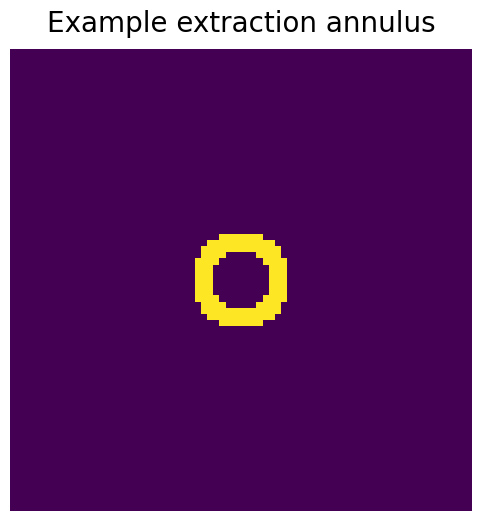

In [5]:
separation = 1.5

_, _, mask_img  = extract_circular_annulus(
    input_residual_frame=residual_frame_1,
    separation=separation,
    size_resolution_elements=4.2,
    annulus_width=0.4)

plt.figure(figsize=(6, 6))
plt.imshow(mask_img)
plt.title("Example extraction annulus", fontsize=20, y=1.02)
_=plt.axis("off")

<div style="text-align: justify">
Define the separations at which we want to extract the pixel values. We use three different regions to show how the noise can vary already within a single dataset.
</div>

In [6]:
# This are the regions we are interested in
fwhm_size = 4.2

# the separations we want to investigate
annulus_width = 0.25

# 1 lambda /D moved out by 0.05 lambda /D to get a small margin 
# to the center (very bright pixel)
separation_1 = 1.05 - annulus_width # 1 lambda /D goes from [0.55, 1.05]
separation_2 = 4.00 - annulus_width # 4 lambda /D goes from [3.5, 4.]
separation_3 = 8.00 - annulus_width  # 8 lambda /D goes from [7.5, 8.]

<div style="text-align: justify">
Compute the Q-Q plot and fit a linear model to show the trend. We use theil sen as it is less sensitive to outliers such as bad pixel. For more information check out the documentation of [gaussian_r2](../../03_package/gaussianity.rst#applefy.gaussianity.residual_tests.gaussian_r2).
</div>

In [7]:
# a dictionary to store the results
result_dict = dict()

# compute the Q-Q results for the residuals of cADI and PCA
for tmp_residual in [("cADI", residual_frame_1), 
                     ("PCA", residual_frame_2)]:
    
    tmp_method_results = dict()
    
    tmp_method_name, tmp_residual_frame = tmp_residual
    
    # Loop over all separations
    for tmp_separation in [separation_1, separation_2, separation_3]:
        
        # 1.) Extract the noise values
        noise_pixel, _, _ = extract_circular_annulus(
            input_residual_frame=tmp_residual_frame, 
            separation=tmp_separation,
            size_resolution_elements=fwhm_size,
            annulus_width=annulus_width)
        
        # 2.) compute r2 and fit a model for the Q-Q plot
        r2, tmp_linear_model, gaussian_samples = gaussian_r2(
            noise_samples=noise_pixel,
            fit_method="theil sen",
            return_fit=True)
        
        # 3.) Save the result to plot them later
        tmp_method_results[tmp_separation] = (noise_pixel, 
                                              gaussian_samples, 
                                              r2,
                                              tmp_linear_model)
        
    result_dict[tmp_method_name] = tmp_method_results

## Create the plot

A small helper function to draws a dashed circle to mark the regions used to compute the Q-Q plots.

In [8]:
def draw_circle(axis_in,
                r_in, r_out):
    
    n, radii = 100, [r_in, r_out]
    theta = np.linspace(0, 2*np.pi, n, endpoint=True)
    xs = np.outer(radii, np.cos(theta))
    ys = np.outer(radii, np.sin(theta))

    # in order to have a closed area, the circles
    # should be traversed in opposite directions
    xs[1,:] = xs[1,::-1]
    ys[1,:] = ys[1,::-1]

    #ax = plt.subplot(111, aspect='equal')
    axis_in.fill(np.ravel(xs)+frame_center[0],
                 np.ravel(ys)+frame_center[1], 
                 fc='white', ec = "none",alpha=0.2)
    axis_in.set_xlim(0, residual_frame_1.shape[0]-1)
    axis_in.set_ylim(0, residual_frame_1.shape[0]-1)
    
    circle = plt.Circle(frame_center, r_in, 
                        ls="--", ec='black', fc="none", alpha=0.5)
    axis_in.add_patch(circle)
    circle = plt.Circle(frame_center, r_out, 
                        ls="--", ec='black', fc="none", alpha=0.5)
    axis_in.add_patch(circle)
    axis_in.invert_yaxis()

A small helper function to plot a Q-Q plot.

In [9]:
def plot_QQ(axis_in,
            results_in,
            label_name=None,
            add_r2=True):
    
    # unpack the results
    noise_pixel, gaussian_samples, r2, tmp_linear_model = results_in
    
    # Plot the Q-Q points
    axis_in.scatter(sorted(gaussian_samples),
                    sorted(noise_pixel), marker="o")
    axis_in.grid()
    
    # Plot the fit model
    x = np.linspace(-5, 5, 100)
    axis_in.plot(x, tmp_linear_model.predict(x.reshape(-1, 1)),
                 'grey', lw=2)
    
    # Set the axis limits
    axis_in.set_xlim(np.min(gaussian_samples)*1.3, 
                     np.max(gaussian_samples)*1.3)
    
    margin = np.max([np.abs(np.min(noise_pixel)*0.2), 
                     np.abs(np.max(noise_pixel)*0.2)])
    axis_in.set_ylim(np.min(noise_pixel) - margin, 
                     np.max(noise_pixel) + margin)
    
    # Add additional information if needed
    if add_r2:
        text = r"$R^2 = $" + "%0.3f"%r2
        axis_in.text(0.7, 0.08, text, ha="center", 
                     fontsize=12, 
                     transform = axis_in.transAxes,
                 bbox={"fc":"white", "ec":"white"})
        
    if label_name is not None:
        axis_in.text(0.18, 0.8, label_name, ha="center",
                     fontsize=14,
                     transform = axis_in.transAxes,
                     bbox={"fc":"white", 
                           "ec":"grey",
                           "boxstyle":"circle" })
    
    # Set the axis labels and make the plot quadratic 
    axis_in.set_aspect(1.0/axis_in.get_data_ratio(), adjustable='box')
    
    axis_in.set_xlabel("Expected \n normal values", fontsize=14)
    axis_in.set_ylabel("Observations", fontsize=14)
    axis_in.get_yaxis().set_label_coords(-0.28, 0.5)
    axis_in.tick_params(axis='both', which='major', labelsize=12)

Create the final plot.

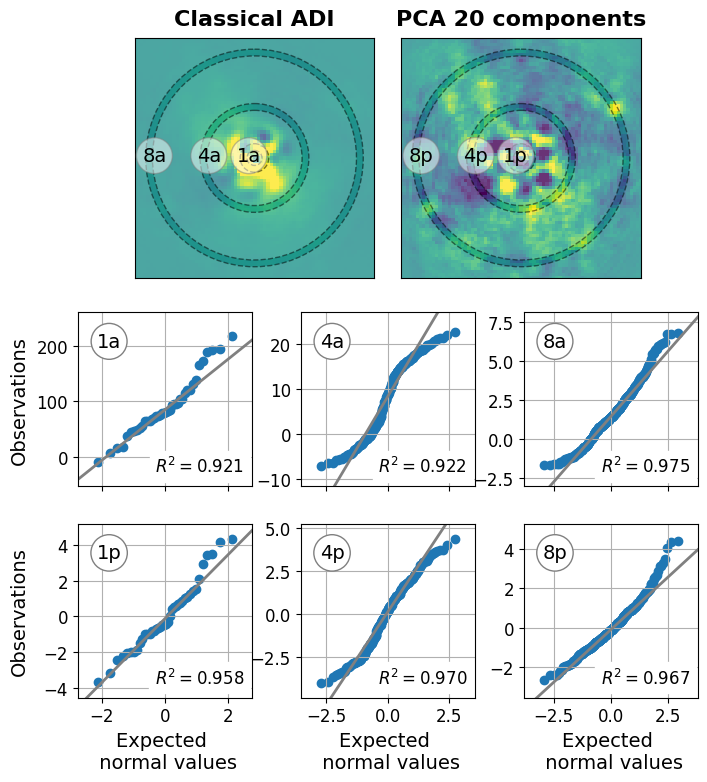

In [10]:
# set the ranges to shade areas outside the masks
range_1_between = (fwhm_size*0.01, 
                   fwhm_size*(separation_1 - annulus_width))
range_2_between = (fwhm_size*(separation_1 + annulus_width),
                   fwhm_size*(separation_2 - annulus_width))
range_3_between = (fwhm_size*(separation_2 + annulus_width),
                   fwhm_size*(separation_3 - annulus_width))
range_4_between = (fwhm_size*(separation_3 + annulus_width), 
                   fwhm_size*20)

# --------------------------------------------------------------------
# 1.) Create Plot Layout
fig = plt.figure(constrained_layout=False, figsize=(8, 10))
gs0 = fig.add_gridspec(2, 1, height_ratios=[1,1.4])
gs0.update(hspace=-0.18, wspace=0.0)

gs00 = gridspec.GridSpecFromSubplotSpec(1, 4, 
                                        subplot_spec=gs0[0],
                                        hspace=0.05, wspace=0.2,
                                        width_ratios=[0.5,4,4,0.5])
residual_ax1 = fig.add_subplot(gs00[1])
residual_ax2 = fig.add_subplot(gs00[2])

gs01 = gridspec.GridSpecFromSubplotSpec(2, 1, 
                                        subplot_spec=gs0[1],
                                        hspace=-0.25,
                                        height_ratios=[1,1])

gs010 = gridspec.GridSpecFromSubplotSpec(1, 3, 
                                        subplot_spec=gs01[0],
                                        wspace=0.28,
                                        width_ratios=[1, 1, 1])

gs011 =  gridspec.GridSpecFromSubplotSpec(1, 3, 
                                          subplot_spec=gs01[1],
                                          wspace=0.28,
                                          width_ratios=[1, 1, 1])

# --------------------------------------------------------------------
# Residual Plots
for tmp_setup in [("Classical ADI", 
                   residual_frame_1, 60, 
                   residual_ax1, "a"),
                  ("PCA 20 components", 
                   residual_frame_2, 4, 
                   residual_ax2, "p")]:
    tmp_name, tmp_frame, tmp_lim, tmp_axis, letter = tmp_setup

    # show the image
    tmp_axis.imshow(tmp_frame, 
                    vmin=-tmp_lim, 
                    vmax=tmp_lim)
    tmp_axis.axes.get_yaxis().set_ticks([])
    tmp_axis.axes.get_xaxis().set_ticks([])
    tmp_axis.set_title(tmp_name, fontsize=16, 
                       fontweight="bold", y=1.02)
    
    # Add the labels
    tmp_axis.text(
        frame_center[0] - (separation_1 + 0.5)*4.2, 
        38, 
        "1" + letter, 
        fontsize=14,
        bbox={"fc":"white", 
              "ec":"grey",
              "boxstyle":"circle", 
              "alpha":0.5})
    tmp_axis.text(frame_center[0] - (separation_2 + 0.5)*4.2,
                  38, "4" + letter,
                  fontsize=14,
                  bbox={"fc":"white", 
                        "ec":"grey",
                        "boxstyle":"circle", 
                        "alpha":0.5})
    
    tmp_axis.text(frame_center[0] - (separation_3 + 0.5)*4.2, 
                  38, "8" + letter, 
                  fontsize=14,
                  bbox={"fc":"white",
                        "ec":"grey",
                        "boxstyle":"circle",
                        "alpha":0.5})

    draw_circle(tmp_axis, *range_1_between)
    draw_circle(tmp_axis, *range_2_between)
    draw_circle(tmp_axis, *range_3_between)
    draw_circle(tmp_axis, *range_4_between)

# --------------------------------------------------------------------
# q-q plots Residual 1
axis11 = fig.add_subplot(gs010[0])
axis12 = fig.add_subplot(gs010[1])
axis13 = fig.add_subplot(gs010[2])
axis21 = fig.add_subplot(gs011[0])
axis22 = fig.add_subplot(gs011[1])
axis23 = fig.add_subplot(gs011[2])

plot_QQ(axis11, result_dict["cADI"][separation_1], "1a")
plot_QQ(axis12, result_dict["cADI"][separation_2], "4a")
plot_QQ(axis13, result_dict["cADI"][separation_3], "8a")

plot_QQ(axis21, result_dict["PCA"][separation_1], "1p")
plot_QQ(axis22, result_dict["PCA"][separation_2], "4p")
plot_QQ(axis23, result_dict["PCA"][separation_3], "8p")

# --------------------------------------------------------------------
# Clean up labels
axis11.set_xticklabels([])
axis12.set_xticklabels([])
axis13.set_xticklabels([])
axis11.set_xlabel("")
axis12.set_xlabel("")
axis13.set_xlabel("")
axis12.set_ylabel("")
axis13.set_ylabel("")
axis22.set_ylabel("")
axis23.set_ylabel("")

fig.patch.set_facecolor('white')
plt.savefig("./04_Residual_statistics.pdf", bbox_inches='tight')